Neural Network Final Project
[Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network](https://arxiv.org/abs/1609.04802)

Students
 - Weihao Wang(1988339)
 - jithin kumar palepu(1988599) 

## Background

This paper proposes a new Neural Networks (GANs) based method for super-resolution image generation. The main problem that paper addresses is of generating high-resolution images from low-resolution images given as input.

The proposed architecture (SRGAN) combines two neural networks, a generator network and a discriminator network. The generator network is responsible for mapping low-resolution images to high-resolution images, while the discriminator network learns to distinguish between the generated high-resolution images and real high-resolution images.

The generator network includes an architecture called Residual Dense Block (RDB) that is designed to learn complex mappings between low-resolution and high-resolution images. The RDB architecture is comprised of several densely connected convolutional layers, which allows the network to better capture the image features.

The discriminator network is designed to distinguish between real and generated images. It uses a deep Convolutional Neural Network (CNN) architecture to learn the features that differentiate real and generated images. The discriminator is trained with two objectives: 
1) to distinguish between real and generated images

2) to guide the generator to produce more photo-realistic images.

Loss Function:
The authors used the perceptual loss function based on the VGG-19 network to provide more photo-realistic details in generated images.

The update:

\begin{align*}
    \hatθ_G=\underset{θ_G}{\operatorname{argmax}}\frac{1}{N}\sum_{n=1}^{N}{l^{SR}(G_{\theta_G}(I^{LR}_n),I^{HR}_n)}
\end{align*}

In [3]:
import os
import random
import numpy as np
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras import layers, Model
from keras.models import Sequential
from keras.applications import VGG19
from sklearn.model_selection import train_test_split
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, Lambda, Add, add, Conv2D, PReLU,BatchNormalization, Flatten

In [4]:
train_dir = "data/original_images"

### Data preparation:

resize_and_save_images takes the original images as input and diverge them into 2 different paths which is low-res(25x25) dir and high-res(100x100) dir.   

In [3]:

def resize_and_save_images(train_dir, size, save_dir):
    for img in os.listdir(train_dir):
        img_array = Image.open(os.path.join(train_dir, img))
        resized_img_array = img_array.resize(size)
        resized_img_array.save(os.path.join(save_dir, img))


In [ ]:
hr_dir = "data/hr_images"
lr_dir = "data/lr_images"
resize_and_save_images(train_dir, (100, 100), hr_dir)
resize_and_save_images(hr_dir, (25, 25), lr_dir)

In [5]:
#Preparinf the dataframe for 3000 images

n = 3000
lr_images = []
hr_images = []
lr_list = os.listdir("data/lr_images")[:n]
hr_list = os.listdir("data/hr_images")[:n]

for img_name in lr_list:
    img = Image.open("data/lr_images/" + img_name)
    lr_images.append(np.array(img))

for img_name in hr_list:
    img = Image.open("data/hr_images/" + img_name)
    hr_images.append(np.array(img))

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)


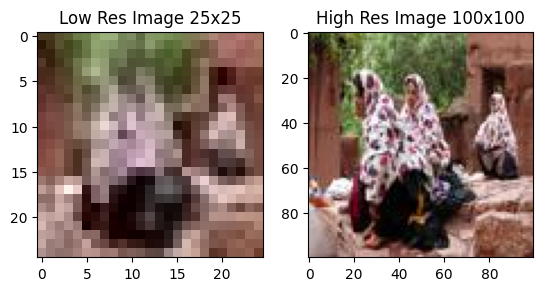

In [6]:
image_number = random.randint(0, len(lr_images)-1)
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(lr_images[image_number])
ax.set_title('Low Res Image 25x25')
ax = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(hr_images[image_number])
ax.set_title('High Res Image 100x100')
plt.show()

In [7]:

def VggNet(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

### Residual Blocks

A residual block from [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) (He et al. 2015) is a stack of layers set in such a way that the output of a layer is taken and added to another layer deeper in the block. The non-linearity is then applied after adding it together with the output of the corresponding layer in the main path.

### Batch Normalization:

This is to improve training and generalization performance. It involves normalizing the input to each layer, in a mini-batch of data, before passing it through the activation function. This has the effect of standardizing the inputs to each layer so that they have a mean of zero and standard deviation of one. By normalizing the input to each layer, batch normalization can help reduce the effects of internal covariate shift, and in turn, help speed up training and improve the performance of deep neural networks. It has become a popular technique in many state-of-the-art neural network architectures.

Specifically on internal covariance shift:

Internal covariate shift is a phenomenon that occurs during training of deep neural networks, where the distribution of the activations of each layer changes as the parameters of the previous layers are updated. This makes it difficult for the subsequent layers to learn stable representations of the input, and can slow down or prevent convergence.

Batch normalization is a technique used in deep learning to address the problem of internal covariate shift. It normalizes the input to each layer by subtracting the batch mean and dividing by the batch standard deviation. This helps to keep the distribution of the activations stable across the layers, and can help to reduce the effects of internal covariate shift. This, in turn, can speed up training and improve the performance of the network.

### Parametric ReLU (PReLU)

ReLU is one of the simplest activation functions that can be described as

\begin{align*}
    x_{\text{ReLU}} := \max(0, x),
\end{align*}

where negative values of $x$ become thresholded at $0$. However, this stops gradient through these negative values, which can hinder training. The authors of [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852) addressed this by introducing a more general ReLU by scaling negative values by some constant $a > 0$:

\begin{align*}
    x_{\text{PReLU}} := \max(0, x) + a * \min(0, x).
\end{align*}

### Upscale block

Upscale function is responsible for increasing the spatial resolution of an image.

During the training of SRGAN, low-resolution images are fed to the generator network, which then upscales the image to produce a high-resolution image. The "upscale" function is typically used as part of this process, taking a low-resolution image as input and producing a higher-resolution image as output.

In the code, the "upscale" function is used to perform upsampling interpolation, which is a common method for upscaling images. Specifically, the function takes a low-resolution image as input, and uses the "resize" function from the OpenCV library to increase the spatial resolution of the image. The resulting image is then returned as output.


### Create gen block:

This function creates and returns a generator model. The function builds a deep neural network with convolutional and upscale blocks that have been described on top, along with residual blocks that help to preserve the details of the original image during the super-resolution process. It uses techniques such as batch normalization, parametric ReLU activation, and skip connections to improve the stability and quality of the generated images. Finally, the model is compiled and returned as a Keras Model object and as same as presented in the paper.



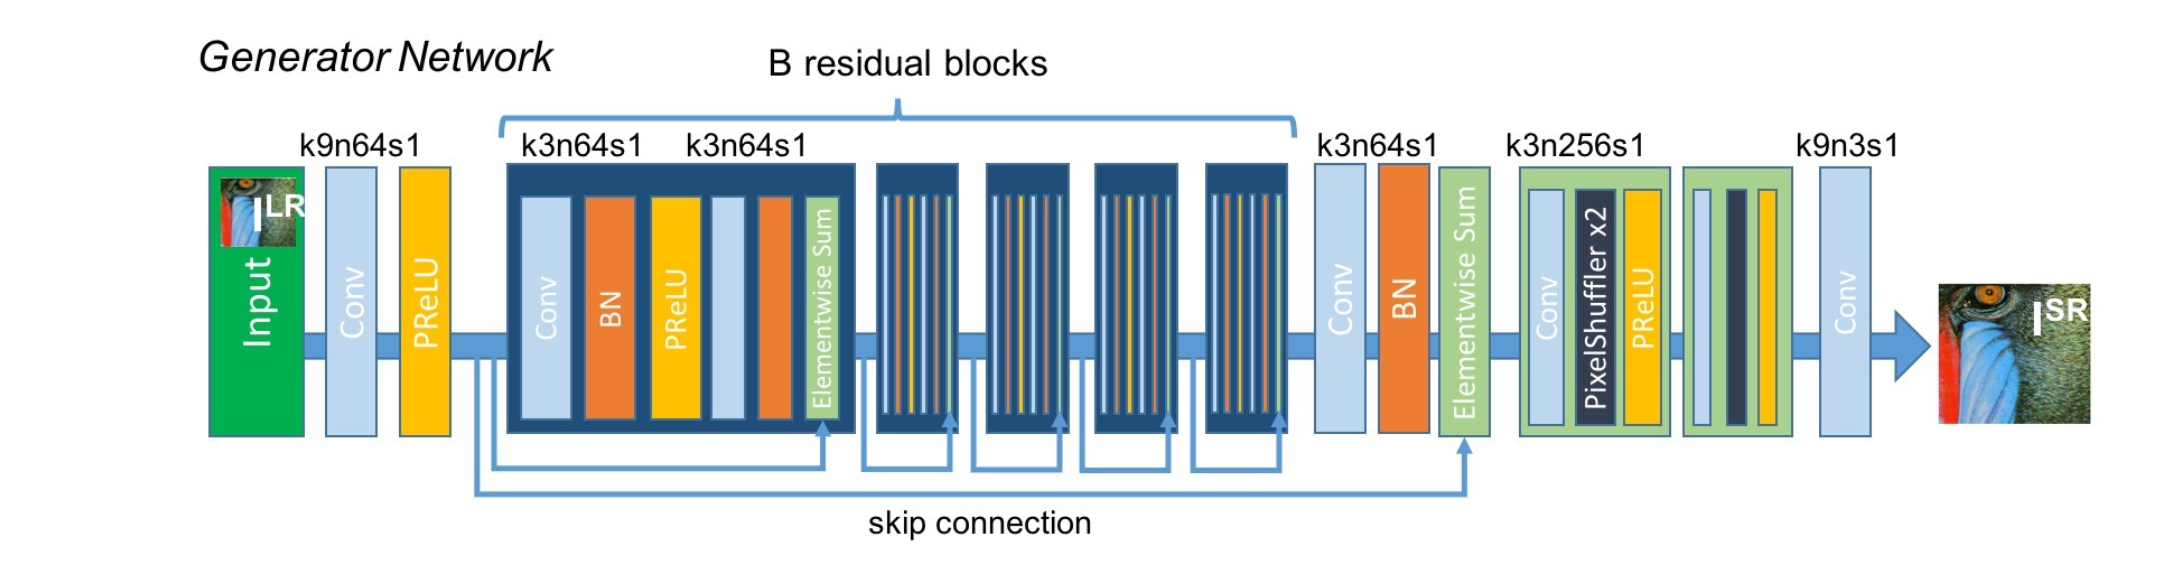




In [7]:
class SRGenerator:
    
    def __init__(self, num_res_block):
        self.num_res_block = num_res_block

    def res_block(self, ip):
        res_model = Conv2D(64, (3,3), padding = "same")(ip)
        res_model = BatchNormalization(momentum = 0.5)(res_model)
        res_model = PReLU(shared_axes = [1,2])(res_model)
        res_model = Conv2D(64, (3,3), padding = "same")(res_model)
        res_model = BatchNormalization(momentum = 0.5)(res_model)
        return add([ip,res_model])

    def upscale_block(self, ip):
        up_model = Conv2D(256, (3,3), padding="same")(ip)
        up_model = UpSampling2D(size = 2 )(up_model)
        up_model = PReLU(shared_axes=[1,2])(up_model)
        return up_model

    def create_gen(self, gen_ip):
        layers = Conv2D(64, (9,9), padding="same")(gen_ip)
        layers = PReLU(shared_axes=[1,2])(layers)
        temp = layers

        for i in range(self.num_res_block):
            layers = self.res_block(layers)

        layers = Conv2D(64, (3,3), padding="same")(layers)
        layers = BatchNormalization(momentum=0.5)(layers)
        layers = add([layers,temp])
        layers = self.upscale_block(layers)
        layers = self.upscale_block(layers)
        op = Conv2D(3, (9,9), padding="same")(layers)
        return Model(inputs=gen_ip, outputs=op)

    
    
    

### Discriminator Network:

In short,
The discriminator takes a low-resolution image as input and aims to distinguish between the output generated by the generator (a super-resolved image) and a high-resolution image from the dataset.

The discriminator network consists of a series of convolutional blocks that extract features from the input image. Each block comprises of a 3x3 convolutional layer followed by batch normalization and a LeakyReLU activation. The number of filters used in each block increases as we move deeper into the network.

The output of the final convolutional block is then flattened and passed through a dense layer with 16 times the number of filters used in the last convolutional block. The output of the dense layer is then passed through another LeakyReLU activation and a final dense layer with sigmoid activation, which produces a binary output indicating whether the input is real or fake (i.e. generated by the generator).

The "discriminator_block" method takes an input tensor (ip), the number of filters (filters) to be used in the convolutional layer, and the stride length (strides) for the convolution operation (default value is 1). If bn is True, a batch normalization layer is added after the convolutional layer.

The method creates a convolutional layer with a 3x3 filter and a specified number of filters (filters). If batch normalization is specified (bn=True), then batch normalization is applied to the output of the convolutional layer. The method then applies a LeakyReLU activation function with a negative slope of 0.2 to the output of the previous layer.

The create_disc method uses multiple calls to the discriminator_block method to create a larger discriminator network.


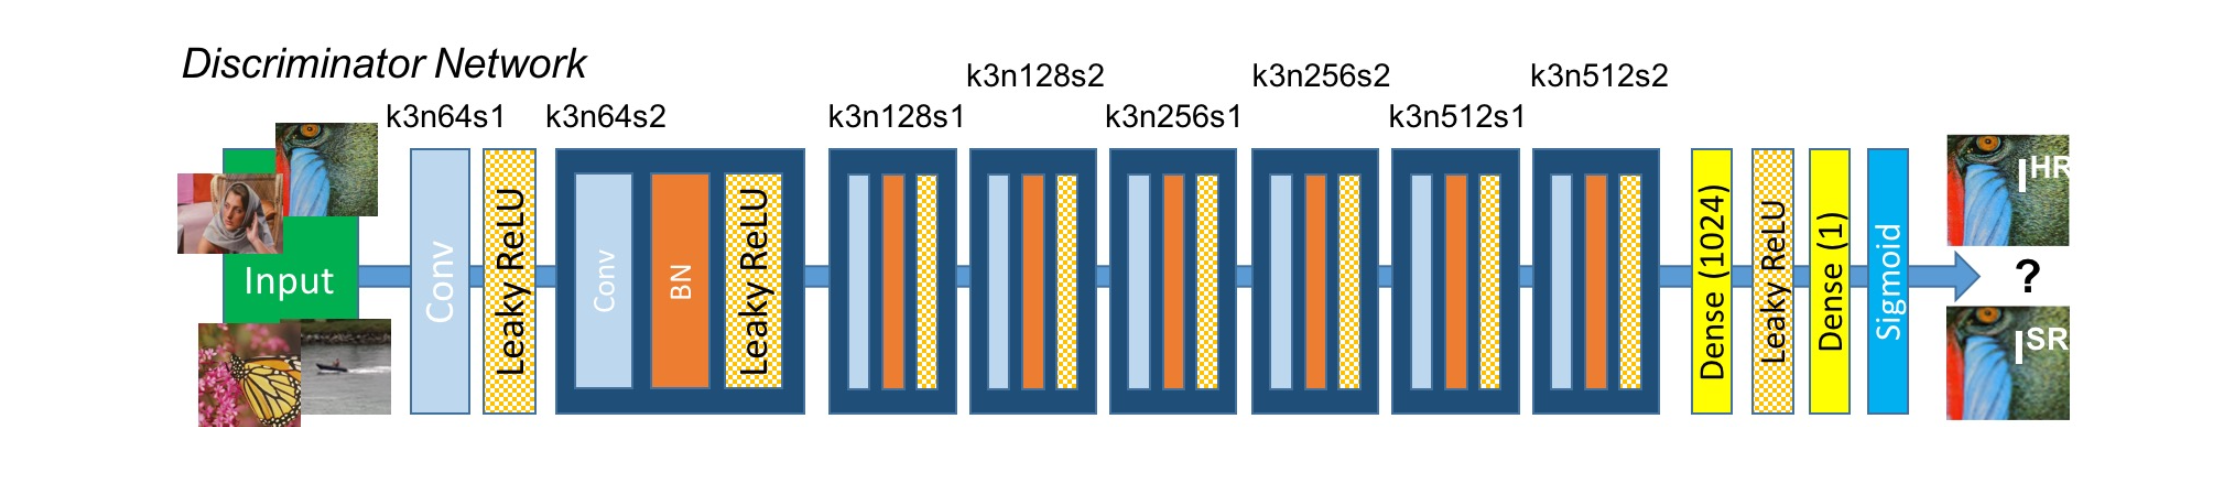


In [8]:

class SRDiscriminator:
    
    def __init__(self):
        pass

    def discriminator_block(self, ip, filters, strides=1, bn=True):
        
        disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip) 
        if bn:
            disc_model = BatchNormalization( momentum=0.8 )(disc_model)

        disc_model = LeakyReLU( alpha=0.2 )(disc_model)

        return disc_model

    
    def create_disc(self, disc_ip):
        
        df = 64

        d1 = self.discriminator_block(disc_ip, df, bn=False)
        d2 = self.discriminator_block(d1, df, strides=2)
        d3 = self.discriminator_block(d2, df*2)
        d4 = self.discriminator_block(d3, df*2, strides=2)
        d5 = self.discriminator_block(d4, df*4)
        d6 = self.discriminator_block(d5, df*4, strides=2)
        d7 = self.discriminator_block(d6, df*8)
        d8 = self.discriminator_block(d7, df*8, strides=2)
        d8_5 = Flatten()(d8)
        d9 = Dense(df*16)(d8_5)
        d10 = LeakyReLU(alpha=0.2)(d9)
        validity = Dense(1, activation='sigmoid')(d10)

        return Model(disc_ip, validity)


### Normalizing values of images and spliting the dataset

In [9]:
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, test_size=0.33, random_state=42)

hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])


In [10]:
#generator object declaration
generator = SRGenerator(num_res_block=16)
generator_input = Input(shape=lr_shape)
generator_model = generator.create_gen(generator_input)
generator_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 25, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 25, 25, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 25, 25, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 25, 25, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [11]:
#Discriminator object declaration
discriminator = SRDiscriminator()
discriminator_input = Input(shape=hr_shape)
discriminator_model = discriminator.create_disc(discriminator_input)
discriminator_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 100, 100, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100, 100, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 50, 50, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 50, 50, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 50, 50, 64)        0         
                                                           

### Loss functions:

1. Perceptual Loss: Perceptual loss is used to measure the difference between the high-resolution and generated images in terms of perceptual quality. It is computed as the mean squared error between the feature maps of the VGG-19 network of the high-resolution and generated images. The VGG-19 network is pre-trained on the ImageNet dataset.

\begin{align*}
    \mathcal{L} &= \mathcal{L}_{VGG} + 10^{-3}\mathcal{L}_{ADV}
\end{align*}

2. Content Loss: The content loss is used to ensure that the high-resolution image and the generated image have similar content. It is calculated as the mean squared error between the high-resolution image and the generated image.

\begin{align*}
    \mathcal{L}_{VGG} &= \left|\left|\phi_{5,4}(I^{\text{HR}}) - \phi_{5,4}(G(I^{\text{LR}}))\right|\right|_2^2
\end{align*}

where $I^{\text{HR}}$ is the original high-resolution image and $I^{\text{LR}}$ is the corresponding low-resolution image.


3. Adversarial Loss: The adversarial loss is used to ensure that the generated image is perceptually similar to the high-resolution image. It is calculated by training a discriminator network to distinguish between the high-resolution images and the generated images. The generator network is then trained to minimize the discriminator's ability to differentiate between the two images. The adversarial loss is computed as the binary cross-entropy loss between the predicted output of the discriminator network and the target output.


\begin{align*}
    \mathcal{L}_{ADV} &= \sum_{n=1}^N -\log D(G(I^{\text{LR}}))
\end{align*}

Note that $-\log D(G(\cdot))$ is used instead of $\log [1 - D(G(\cdot))]$ for better gradient behavior.

In [12]:
#vgg initiation
vgg = VggNet((100,100,3))
vgg.trainable = False

### Creating the GAN network:

In [13]:

def create_GAN(gen_model, disc_model, vgg, lr_ip, hr_ip):
    
    gen_img = gen_model(lr_ip) 
    gen_features = vgg(gen_img)
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

gan_model = create_GAN(generator_model, discriminator_model, vgg, generator_input,discriminator_input)


In [14]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")

gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 25, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 100, 100, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            30384961    ['model[0][0]']            


The epochs and batch_size variables are used to determine the number of iterations needed to complete one full epoch of training data.

Then we initialize two lists (empty), train_lr_batches and train_hr_batches, and then loops through the training data, which is in two arrays: hr_train and lr_train.

For each batch in the training data, the code extracts a slice of size batch_size from hr_train and lr_train arrays starting from the index start_idx and ending at the index end_idx. These slices are then appended to their respective lists, train_hr_batches and train_lr_batches.


In [15]:
epochs = 20
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

Within each epoch here, the program will loop through each batch of high-resolution (HR) and low-resolution (LR) images and trains the discriminator on both real and generated (fake) images. The generator is then trained on a combination of adversarial and content losses. The losses for each batch are saved to lists and are later averaged to report the progress of the training.

After each epoch, the average losses are printed, and the generator model is saved to a file. Finally, the trained generator model is saved to a file named "exp" plus the final epoch number.

In [ ]:


for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator_model.predict_on_batch(lr_imgs) #Fake images
        
        #training discriminator first on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator_model.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator_model.train_on_batch(hr_imgs, real_label)
        
        #Now, trainining the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #2 losses: adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator_model.save("gen_e_"+ str(e+1) +".h5")

generator_model.save("exp"+ str(e) +".h5")
 

### Visualization of the images

the function plot_images will display the input image and original and also the image generated by the generator network. 

In [4]:

def plot_images(lr_path, hr_path, generator):
    
    lr_test_image = plt.imread(lr_path)
    hr_test_image = plt.imread(hr_path)

    #norm img
    lr_test_image = lr_test_image / 255.
    hr_test_image = hr_test_image / 255.
    
    lr_test_image = np.expand_dims(lr_test_image, axis=0)
    sreeni_hr = np.expand_dims(hr_test_image, axis=0)

    # Generate HR image from the LR image using the generator
    generated_hr = generator.predict(lr_test_image)

    # Plot all three images
    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('LR Image')
    plt.imshow(lr_test_image[0,:,:,:])
    plt.subplot(232)
    plt.title('Superresolution')
    plt.imshow(generated_hr[0,:,:,:])
    plt.subplot(233)
    plt.title('Orig. HR image')
    plt.imshow(hr_test_image[:,:,:])
    plt.show()


2023-02-14 15:00:51.754602: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 265ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


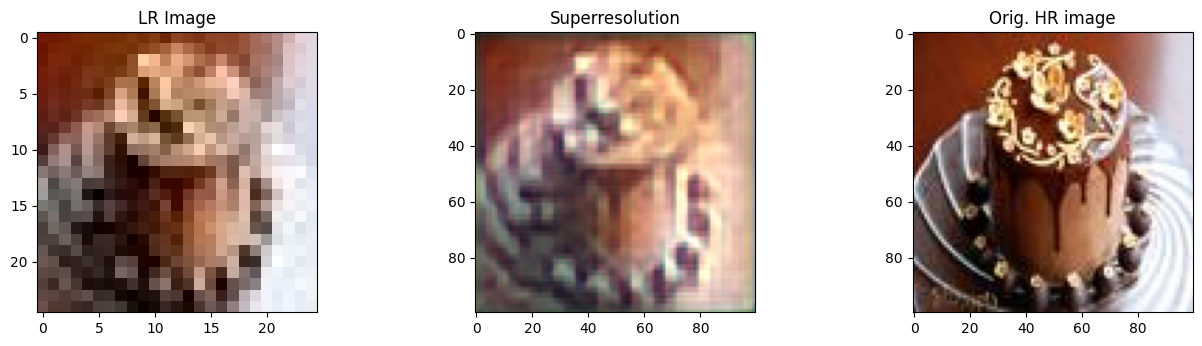

1/1 [==============================] - 0s 63ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


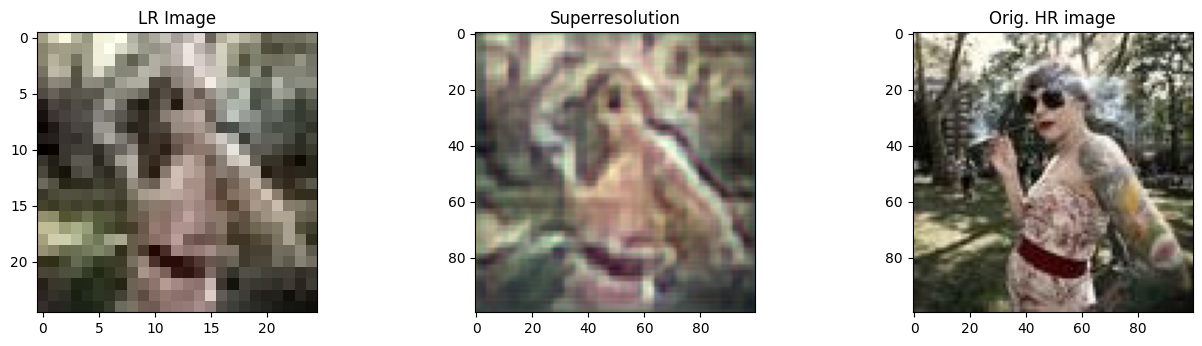

In [5]:
from keras.models import load_model

generator_model = load_model('gen_e_20.h5', compile=False)
plot_images("data/lr_images/im3.jpg", "data/hr_images/im3.jpg", generator_model)
plot_images("data/lr_images/im1.jpg", "data/hr_images/im1.jpg", generator_model)

In [16]:

lr_test_image = plt.imread("data/lr_images/im4.jpg")
hr_test_image = plt.imread("data/hr_images/im4.jpg")

lr_test_image = lr_test_image / 255
hr_test_image = hr_test_image / 255
    
lr_test_image = np.expand_dims(lr_test_image, axis=0)
hr_test_image = np.expand_dims(hr_test_image, axis=0)

generated_hr = generator_model.predict(lr_test_image)
print(generated_hr.shape, hr_test_image.shape)

1/1 [==============================] - 0s 59ms/step
(1, 100, 100, 3) (1, 100, 100, 3)


### Calculating the PSNR for the generated images and original images

In [17]:
def calculate_psnr(img1, img2, max_value=255):

    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))


In [19]:
from skimage.metrics import structural_similarity as compare_ssim
import cv2

im1 = np.squeeze(generated_hr)
im2 = np.squeeze(hr_test_image)

score = compare_ssim(im1, im2, multichannel=True)
print("SSIM: {}".format(score))
print("PSNR: {}".format(calculate_psnr(hr_test_image, generated_hr)))

SSIM: 0.6990508437156677
PSNR: 63.192178746561225


/var/folders/wt/28w689qd0jlgv8wtl7h843k00000gn/T/ipykernel_5620/3532269043.py:7: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  score = compare_ssim(im1, im2, multichannel=True)


From the paper, the resulted PSNR was provided as 26.92, SSIM was given at 0.7611 but the model was trained on 350 thousand images, where as the above program was trained for 20 epochs on 3000 images. The obtained mean of PSNR is 64 and SSIM was 0.699.